In [3]:
import os

os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.0/bin")
os.add_dll_directory("C:/tools/cuda/bin")

<AddedDllDirectory('C:/tools/cuda/bin')>

In [45]:
# from utils.conf import ROOT_DIR
ROOT_DIR = "C:/Users/anass/my_ds/fingerprint_class"
import os
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

In [17]:
def extract_data(path, img_size):
    for img in os.listdir(path):
        ext = (img.split('_')[-1]).split('.')[0]
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))
        if ext == 'CR':
            data_cr.append(img_resize)
        if ext == 'Zcut':
            data_zcut.append(img_resize)
        if ext == 'Obl':
            data_obl.append(img_resize)
    return data_cr, data_zcut, data_obl

def loading_data(path, img_size):
    print("loading data from: ",path)
    data = []
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))
        data.append(img_resize)
    return data

In [26]:
data_cr, data_zcut, data_obl = [], [], []
src_data = os.path.join(ROOT_DIR,"SOCOFing")
data_cr, data_zcut, data_obl = extract_data(os.path.join(src_data, os.path.join("Altered","Altered-Easy")), img_size=28)
# data_cr, data_zcut, data_obl = extract_data(os.path.join(src_data, os.path.join("Altered","Altered-Medium")), img_size=28)
# data_cr, data_zcut, data_obl = extract_data(os.path.join(src_data, os.path.join("Altered","Altered-Hard")), img_size=28)

In [34]:
data_real = loading_data(os.path.join(src_data, "Real"), img_size=28)

data_real = data_real[:len(data_cr)]

x_cr_train, x_cr_test = train_test_split(data_cr, test_size=0.3, shuffle=True, random_state=42)
x_real_train, x_real_test = train_test_split(data_real, test_size=0.3, shuffle=True, random_state=42)

x_cr_train = np.array(x_cr_train).astype('float32') / 255.
x_cr_test = np.array(x_cr_test).astype('float32') / 255.
x_cr_train = tf.expand_dims(x_cr_train, axis=-1)
x_cr_test = tf.expand_dims(x_cr_test, axis=-1)

x_real_train = np.array(x_real_train).astype('float32') / 255.
x_real_test = np.array(x_real_test).astype('float32') / 255.
x_real_train = tf.expand_dims(x_real_train, axis=-1)
x_real_test = tf.expand_dims(x_real_test, axis=-1)

print ("data cr train", x_cr_train.shape)
print ("data cr test", x_cr_test.shape)
print("data real train", x_real_train.shape)
print("data real test", x_real_test.shape)

loading data from:  C:/Users/anass/my_ds/fingerprint_class\SOCOFing\Real


In [30]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(32, (3,3), activation='relu', padding='same'),
          layers.MaxPooling2D(2),
          layers.Conv2D(16, (3,3), activation='relu', padding='same'),
          layers.MaxPooling2D(2),
          layers.Conv2D(8, (3,3), activation='relu', padding='same')
        ])
        self.decoder = tf.keras.Sequential([
          layers.Conv2D(8, (3,3), activation='relu', padding='same'),
          layers.UpSampling2D(2),
          layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same'),
          layers.UpSampling2D(2),
          layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"],cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

tf.keras.backend.clear_session()
with mirrored_strategy.scope():
    autoencoder = Autoencoder()
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
    autoencoder.fit(x_cr_train, x_real_train,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_cr_test, x_real_test))

encoded_imgs = autoencoder.encoder(x_cr_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_cr_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

loading data from:  C:/Users/anass/my_ds/fingerprint_class\SOCOFing\Altered\Altered-Easy
loading data from:  C:/Users/anass/my_ds/fingerprint_class\SOCOFing\Altered\Altered-Medium
loading data from:  C:/Users/anass/my_ds/fingerprint_class\SOCOFing\Altered\Altered-Hard


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


x_train dimensions:  (39416, 28, 28, 1)
x_test dimensions:  (9854, 28, 28, 1)
y_train dimensions:  (39416, 2)
y_test dimensions:  (9854, 2)
x_train dimensions:  (37445, 28, 28, 1)
x_val dimensions:  (1971, 28, 28, 1)
y_train dimensions:  (37445, 2)
y_val dimensions:  (1971, 2)


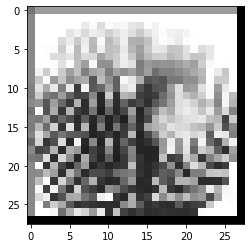

In [132]:
def extract_label(img_path, train = True):
    filename, _ = os.path.splitext(os.path.basename(img_path))
    subject_id, etc = filename.split('__')
    if train:
        gender, lr, finger, _ = etc.split('_')[:4]
    gender = 0 if gender=='M' else 1
    return gender

def loading_data(path,train, img_size):
    print("loading data from: ",path)
    data = []
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))
        label = extract_label(os.path.join(path, img),train)
        data.append([label[0], img_resize])
    return data

src_data = os.path.join(ROOT_DIR,"SOCOFing")
easy_data = loading_data(os.path.join(src_data, os.path.join("Altered","Altered-Easy")), True, 28)
medium_data = loading_data(os.path.join(src_data, os.path.join("Altered","Altered-Medium")), True, 28)
hard_data = loading_data(os.path.join(src_data, os.path.join("Altered","Altered-Hard")), True, 28)
data = np.concatenate([easy_data, medium_data, hard_data], axis=0)
import random

random.shuffle(data)

img, labels = [], []
for label, feature in data:
    labels.append(label)
    img.append(feature)
img = np.array(img).reshape(-1, 28, 28, 1)
labels = tf.keras.utils.to_categorical(labels)

x_train, x_test, y_train, y_test = train_test_split(img, labels, test_size=0.2, random_state=0)

print("x_train dimensions: ", x_train.shape)
print("x_test dimensions: ", x_test.shape)
print("y_train dimensions: ", y_train.shape)
print("y_test dimensions: ", y_test.shape)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05, random_state=0)

datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True)

def normalize(data):
    data = data.astype("float32")
    data = data/255
    return data

print("x_train dimensions: ", x_train.shape)
print("x_val dimensions: ", x_val.shape)
print("y_train dimensions: ", y_train.shape)
print("y_val dimensions: ", y_val.shape)
import matplotlib.pyplot as plt

plt.imshow(x_train[40])

In [130]:
# define the names of 2 classes (gender)
classes = ['Male', 'Female']
def predict_class(filename, model):
    img = load_img(filename, target_size=(28, 28))
    
    # convert image to array
    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
    img_resize = cv2.resize(img_array, (img_size, img_size))
    img = np.array(img_resize).reshape(-1, 28, 28, 1)
    # scale the array elements
    img = img.astype('float32')
    img = img/255
    
    result = model.predict(img)
    print(result)
    dict2 ={}
    for i in range(2):
        dict2[result[0][i]] = classes[i]
    
    res = result[0]
    res.sort()
    # Pick the top three predictions for display
    res = res[::-1]
    results = res[:2]
    
    return dict2[results[0]], (results[i]*100).round(2)


def results(model, epoch, batch_size):
    r = model.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, validation_data=(x_test, y_test), verbose=1)
    acc = model.evaluate(x_test, y_test)
    print("test set loss: ", acc[0])
    print("test set accuracy: ", acc[1]*100)
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, r.history['accuracy'])
    plt.plot(epoch_range, r.history['val_accuracy'])
    plt.title('Classification Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(epoch_range,r.history['loss'])
    plt.plot(epoch_range, r.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()

In [ ]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(32, (3,3), activation='relu', padding='same'),
          layers.MaxPooling2D(2),
          layers.Conv2D(16, (3,3), activation='relu', padding='same'),
          layers.MaxPooling2D(2),
          layers.Conv2D(8, (3,3), activation='relu', padding='same')
        ])
        self.decoder = tf.keras.Sequential([
          layers.Conv2D(8, (3,3), activation='relu', padding='same'),
          layers.UpSampling2D(2),
          layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same'),
          layers.UpSampling2D(2),
          layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"],cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

tf.keras.backend.clear_session()
with mirrored_strategy.scope():
    autoencoder = Autoencoder()
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
    autoencoder.fit(x_cr_train, x_real_train,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_cr_test, x_real_test))

encoded_imgs = autoencoder.encoder(x_cr_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [144]:
decoded_imgs

array([[[[0.45352152],
         [0.63026905],
         [0.60288197],
         ...,
         [0.6017585 ],
         [0.56972045],
         [0.05414625]],

        [[0.54265904],
         [0.96989006],
         [0.9855322 ],
         ...,
         [0.98471767],
         [0.9677711 ],
         [0.05017381]],

        [[0.527651  ],
         [0.9746361 ],
         [0.98154026],
         ...,
         [0.9722649 ],
         [0.9650581 ],
         [0.02141136]],

        ...,

        [[0.51159406],
         [0.7603799 ],
         [0.6722875 ],
         ...,
         [0.6375738 ],
         [0.7012901 ],
         [0.03366411]],

        [[0.50641954],
         [0.7411598 ],
         [0.7024604 ],
         ...,
         [0.6971554 ],
         [0.754543  ],
         [0.067124  ]],

        [[0.13636364],
         [0.07296414],
         [0.04199611],
         ...,
         [0.02573802],
         [0.0694385 ],
         [0.03493465]]],


       [[[0.45284164],
         [0.6254212 ],
         [0.59

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1

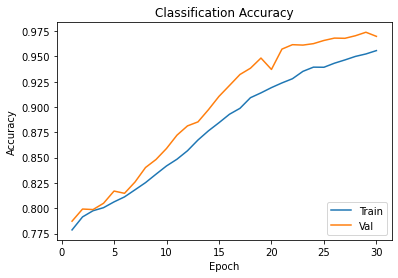

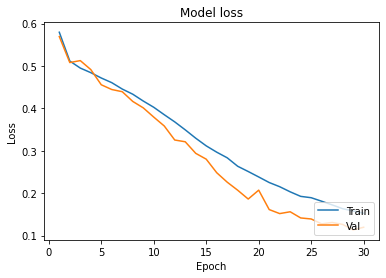

In [94]:
tf.keras.backend.clear_session()
weight_decay = 1e-4
with mirrored_strategy.scope():
    model_f = Sequential([
            Conv2D(32, (3, 3), activation = 'relu', padding = 'same',kernel_regularizer = tf.keras.regularizers.l2(weight_decay), input_shape = (28, 28, 1)),
            BatchNormalization(),
            Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer =tf.keras.regularizers.l2(weight_decay), padding = 'same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.2),
            Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(weight_decay), padding = 'same'),
            BatchNormalization(),
            Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer =
            tf.keras.regularizers.l2(weight_decay), padding = 'same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.3),
            Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer =
            tf.keras.regularizers.l2(weight_decay), padding = 'same'),
            BatchNormalization(),
            Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer =
            tf.keras.regularizers.l2(weight_decay), padding = 'same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.3),
            Flatten(),
            Dense(128, activation = 'relu'),
            Dense(2, activation = 'softmax')
    ])
    model_f.summary()
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model_f.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    results(model_f, 30, 128)

In [142]:
def extract_label(img_path, train = True):
    filename, _ = os.path.splitext(os.path.basename(img_path))
    subject_id, etc = filename.split('__')
    if train:
        gender, lr, finger, _ = etc.split('_')[:4]
    gender = 0 if gender=='M' else 1
    return gender

def loading_data(path,train, img_size):
    print("loading data from: ",path)
    data = []
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))
        label = extract_label(os.path.join(path, img),train)
        data.append([label, img_resize])
    return data
real_data = loading_data(os.path.join(src_data, os.path.join("Real")), True, 28)
img, labels = [], []
for label, feature in real_data:
    labels.append(label)
    img.append(feature)
img = np.array(img).reshape(-1, 28, 28, 1)

loading data from:  C:/Users/anass/my_ds/fingerprint_class\SOCOFing\Real


6000

In [143]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model_f.predict(img)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(labels, y_pred))
print('Classification Report')
target_names = ['Male', 'Female']
print(classification_report(labels, y_pred, target_names=target_names))

Confusion Matrix
[[4676   94]
 [  46 1184]]
Classification Report
              precision    recall  f1-score   support

        Male       0.99      0.98      0.99      4770
      Female       0.93      0.96      0.94      1230

    accuracy                           0.98      6000
   macro avg       0.96      0.97      0.96      6000
weighted avg       0.98      0.98      0.98      6000



In [131]:
file_1 = 'C:/Users/anass/my_ds/fingerprint_class/SOCOFing/Real/3__M_Right_little_finger.BMP'
predict_class(file_1, model_f)

NameError: name 'path' is not defined

In [73]:
# define the names of 2 classes (gender)
classes = ['Thumb', 'Index', 'Middle', 'Ring', 'Little']
def predict_finger(filename, model):
    img = load_img(filename, target_size=(28, 28))
    
    # convert image to array
    img = img_to_array(img)
    img = img.reshape(-1, 28, 28, 1)
    
    # scale the array elements
    img = img.astype('float32')
    img = img/255
    
    result = model.predict(img)
    dict2 ={}
    for i in range(5):
        dict2[result[0][i]] = classes[i]
    
    res = result[0]
    res.sort()
    # Pick the top three predictions for display
    results = res[::-1]
    
    print("Top predictions of these images are: ")
    for i in range(3):
        print(f"{dict2[results[i]]} : {(results[i]*100).round(2)}")
    print('The image given as input')
    plt.imshow(load_img(filename))
    plt.show()

In [ ]:
tf.keras.backend.clear_session()
weight_decay = 1e-4
with mirrored_strategy.scope():
    model = Sequential([
          Conv2D(32, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(weight_decay), input_shape = (96, 96, 1)),
          BatchNormalization(),
          MaxPooling2D((2, 2)),
          Dropout(0.2),
          Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(weight_decay), padding = 'same'),
          BatchNormalization(),
          MaxPooling2D((2, 2)),
          Dropout(0.3),
          Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(weight_decay), padding = 'same'),
          BatchNormalization(),
          MaxPooling2D((2, 2)),
          Dropout(0.3),
          Flatten(),
          Dense(128, activation = 'relu'),
          Dense(2, activation = 'softmax')
    ])
    model.summary()
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    results(model, 30, 128)

In [ ]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(32, (3,3), activation='relu', padding='same'),
          layers.MaxPooling2D(2),
          layers.Conv2D(16, (3,3), activation='relu', padding='same'),
          layers.MaxPooling2D(2),
          layers.Conv2D(8, (3,3), activation='relu', padding='same')
        ])
        self.decoder = tf.keras.Sequential([
          layers.Conv2D(8, (3,3), activation='relu', padding='same'),
          layers.UpSampling2D(2),
          layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same'),
          layers.UpSampling2D(2),
          layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"],cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

tf.keras.backend.clear_session()
with mirrored_strategy.scope():
    autoencoder = Autoencoder()
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
    autoencoder.fit(x_cr_train, x_real_train,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_cr_test, x_real_test))

encoded_imgs = autoencoder.encoder(x_cr_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

predict